<a href="https://colab.research.google.com/github/amangupta2/ai_weather/blob/main/Comparing_WeatherBench_with_Meteostat_radars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Note that pip might complain about some versions but the notebook should still work as expected.
!pip install git+https://github.com/google-research/weatherbenchX.git
#!pip install stationbench
!pip install cartopy
! pip install netCDF4
! pip install meteostat

  Cloning https://github.com/google-research/weatherbenchX.git to /tmp/pip-req-build-v5d2d765
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/weatherbenchX.git /tmp/pip-req-build-v5d2d765
  Resolved https://github.com/google-research/weatherbenchX.git to commit 0fa584bfcdbcb2c33002b23410bb920b97d8ca88
  Preparing metadata (setup.py) ... done


In [2]:
import apache_beam as beam
import numpy as np
import xarray as xr
import weatherbenchX
from weatherbenchX.data_loaders import xarray_loaders
from weatherbenchX.metrics import deterministic
from weatherbenchX.metrics import base as metrics_base
from weatherbenchX import aggregation
from weatherbenchX import weighting
from weatherbenchX import binning
from weatherbenchX import time_chunks
from weatherbenchX import beam_pipeline
#import stationbench

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#
from netCDF4 import Dataset

#import numpy as np
from datetime import datetime
#import matplotlib.pyplot as plt
from meteostat import Point, Daily, Monthly, Hourly, Stations
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

In [4]:
from google.colab import auth, drive

# Authenticate user
auth.authenticate_user()
# connect Google Drive
drive.mount('/content/drive')
# load file
f = '/content/drive/MyDrive/ERA5_lsm.nc'
nc = Dataset(f)
lsm = nc.variables['lsm'][0,:,:]

Mounted at /content/drive


In [30]:
# Defining error metric functions

# Compute latitude weighted RMSE wrt ERA5: globally and over India
def RMSE(pred, truth, lat):

  anom = pred - truth
  factor = np.cos(np.pi*lat/180.)
  factor2 = np.cos(np.pi*lat[208:329]/180.)

  rmse_global = np.sqrt(np.mean(np.mean(anom**2,2),1)) #np.sqrt(np.mean(np.mean(anom**2,2)*factor[np.newaxis,:],1)/np.mean(factor))
  rmse_india  = np.sqrt(np.mean(np.mean(anom[:,208:329,272:393]**2,2),1)) #np.sqrt(np.mean(np.mean(anom[:,208:329,272:393]**2,2)*factor2[np.newaxis,:],1)/np.mean(factor2))

  return rmse_global, rmse_india

# Compute latitude-weighted MAE: globally and over India
def MAE(pred, truth, lat):

  anom = pred - truth
  factor = np.cos(np.pi*lat/180.)
  factor2 = np.cos(np.pi*lat[208:329]/180.)

  mae_global = np.mean(np.mean(np.abs(anom),2),1)
  mae_india  = np.mean(np.mean(np.abs(anom)[:,208:329,272:393],2),1)

  return mae_global, mae_india


# Compute latitude-weighted anomaly correlation coefficient: globally and over India
def ACC(pred, truth, lat):
  ...

In [25]:
# Load radar data

start = datetime(2020,1,1,0,0,0)
end   = datetime(2020,1,31,23,0,0)

# Bhadla solar park
#bhadla = Point(27.5175957,71.9278131)
delhi       = Point(28.6439835,76.9280785)
#bhuj        = Point(23.2420,69.6669) # not complete
madras      = Point(13.0, 80.1833)
agartala    = Point(23.8315, 91.2868)
calcutta    = Point(22.5333, 88.3333)
bhopal      = Point(23.2833, 77.35)

delhi_data       = Hourly(delhi,start,end) # daily
#bhuj_data        = Hourly(bhuj,start,end)
madras_data      = Hourly(madras,start,end)
agartala_data    = Hourly(agartala,start,end)
calcutta_data    = Hourly(calcutta,start,end)
bhopal_data      = Hourly(bhopal,start,end)

delhi_data       = delhi_data.fetch()
#bhuj_data        = bhuj_data.fetch()
madras_data      = madras_data.fetch()
agartala_data    = agartala_data.fetch()
calcutta_data    = calcutta_data.fetch()
bhopal_data      = bhopal_data.fetch()

In [20]:
delhi_data['temp'][0::6].shape

(1464,)

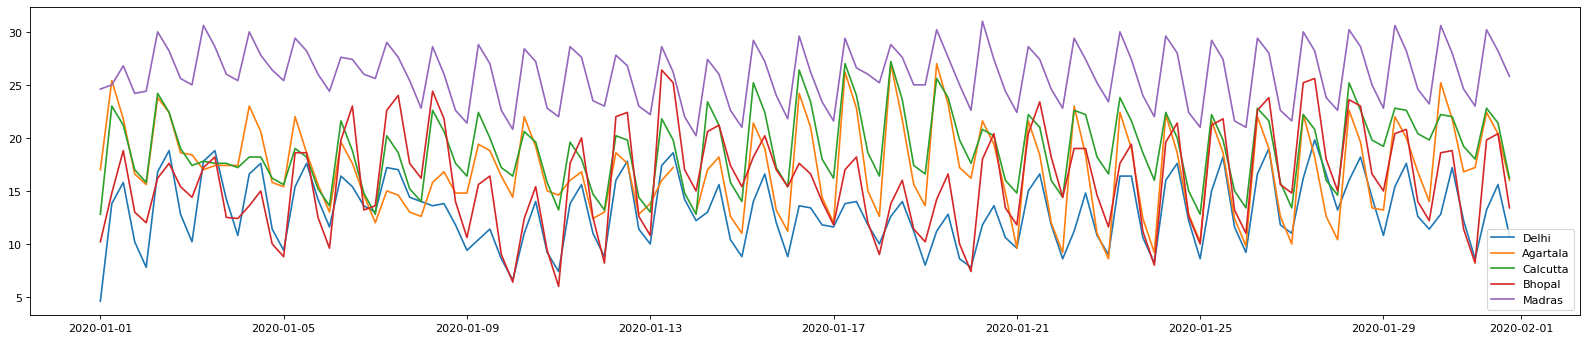

In [26]:
# Bhopal and Agartala have broken data. Use the other three

fig=plt.figure(figsize=(25, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(delhi_data['temp'][0::6], color='C0', label='Delhi')
plt.plot(agartala_data['temp'][0::6], color='C1', label='Agartala')
plt.plot(calcutta_data['temp'][0::6], color='C2', label='Calcutta')
plt.plot(bhopal_data['temp'][0::6], color='C3', label='Bhopal')
plt.plot(madras_data['temp'][0::6], color='C4', label='Madras')
plt.legend()

In [27]:
# Loading WeatherBench data
# data guide: https://weatherbench2.readthedocs.io/en/latest/data-guide.html

# Ground truth to compare to
target_path_era5_analysis     = 'gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr'
target_path_hres_analysis     = 'gs://weatherbench2/datasets/hres_t0/2016-2022-6h-1440x721.zarr'

# ============ AI + TRADITIONAL FORECASTS ====================
prediction_path_pangu         = 'gs://weatherbench2/datasets/pangu/2018-2022_0012_0p25.zarr'
prediction_path_graphcast     = 'gs://weatherbench2/datasets/graphcast/2020/date_range_2019-11-16_2021-02-01_12_hours_derived.zarr'
prediction_path_fuxi          = 'gs://weatherbench2/datasets/fuxi/2020-1440x721.zarr'

prediction_path_panguoper     = 'gs://weatherbench2/datasets/pangu_hres_init/2020_0012_0p25.zarr'
prediction_path_graphcastoper = 'gs://weatherbench2/datasets/graphcast_hres_init/2020/date_range_2019-11-16_2021-02-01_12_hours_derived.zarr'

# traditional model forecasts
prediction_path_ifshres_forecast  = 'gs://weatherbench2/datasets/hres_t0/2016-2022-6h-1440x721.zarr'
prediction_path_ifsens_forecast   = 'gs://weatherbench2/datasets/ifs_ens/2018-2022-1440x721_mean.zarr' # can remove "_mean" to get the full ensemble
prediction_path_era5_forecast     = 'gs://weatherbench2/datasets/era5-forecasts/2020-1440x721.zarr'

#prediction_path_neuralgcm    = 'gs://weatherbench2/datasets/fuxi/2020-1440x721.zarr'
#prediction_path_sphericalcnn = ''gs://weatherbench2/datasets/sphericalcnn/2020-240x121_equiangular_with_poles.zarr''


In [28]:
# All datasets available at 6-hourly resolution
time1='2020-01-01T00:00:00.000000000'
time2='2020-01-31T18:00:00.000000000' # 02 to 05 for testing


ds_era5 = xr.open_zarr(
    target_path_era5_analysis,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_hres = xr.open_zarr(
    target_path_hres_analysis,
    chunks=None,
    storage_options=dict(token='anon'),
)


ds_pangu = xr.open_zarr(
    prediction_path_pangu,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_graphcast = xr.open_zarr(
    prediction_path_graphcast,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_fuxi = xr.open_zarr(
    prediction_path_fuxi,
    chunks=None,
    storage_options=dict(token='anon'),
)


ds_panguoper = xr.open_zarr(
    prediction_path_panguoper,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_graphcastoper = xr.open_zarr(
    prediction_path_graphcastoper,
    chunks=None,
    storage_options=dict(token='anon'),
)


# traditional
ds_ifshres_fcst = xr.open_zarr(
    prediction_path_ifshres_forecast,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_ifsens_fcst = xr.open_zarr(
    prediction_path_ifsens_forecast,
    chunks=None,
    storage_options=dict(token='anon'),
)
ds_era5_fcst = xr.open_zarr(
    prediction_path_era5_forecast,
    chunks=None,
    storage_options=dict(token='anon'),
)

# forecast is made every 6 hours using initial conditions every 12 hours. so time axis has 2 samples per day, but the prediction_delta has 6 samples per timestamp
data_era5          = ds_era5.sel(time=slice(time1, time2))
data_hres          = ds_hres.sel(time=slice(time1, time2))
# --------------------------------------------------------------------
data_pangu         = ds_pangu.sel(time=slice(time1, time1))
data_graphcast     = ds_graphcast.sel(time=slice(time1, time1))
data_fuxi          = ds_fuxi.sel(time=slice(time1, time1))
# --------------------------------------------------------------------
data_panguoper     = ds_panguoper.sel(time=slice(time1, time1))
data_graphcastoper = ds_graphcastoper.sel(time=slice(time1, time1))
# --------------------------------------------------------------------
data_ifshres_fcst  = ds_ifshres_fcst.sel(time=slice(time1, time2))
data_ifsens_fcst   = ds_ifsens_fcst.sel(time=slice(time1, time1))
data_era5_fcst     = ds_era5_fcst.sel(time=slice(time1, time1))

print('Done')

Done


In [29]:
#data_hres
#data_pangu
#data_graphcast
#data_fuxi

p1=0
p2=20 # 8

lat = data_era5['latitude'].values
lon = data_era5['longitude'].values

#p_era5 = data_era5['level'].values
t_era5 = data_era5['2m_temperature']
u_era5 = data_era5['10m_u_component_of_wind']
v_era5 = data_era5['10m_v_component_of_wind']

#p_hres = data_hres['level'].values
t_hres = data_hres['2m_temperature'].values
u_hres = data_hres['10m_u_component_of_wind'].values
v_hres = data_hres['10m_v_component_of_wind'].values

#p_pangu = data_pangu['level'].values
t_pangu = data_pangu['2m_temperature'][0,p1:p2,:,:].values
u_pangu = data_pangu['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_pangu = data_pangu['10m_v_component_of_wind'][0,p1:p2,:,:].values

#p_graphcast = data_graphcast['level'].values
t_graphcast = data_graphcast['2m_temperature'][0,p1:p2,:,:].values
u_graphcast = data_graphcast['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_graphcast = data_graphcast['10m_v_component_of_wind'][0,p1:p2,:,:].values

#p_fuxi = data_fuxi['level'].values
t_fuxi = data_fuxi['2m_temperature'][0,p1:p2,:,:].values
u_fuxi = data_fuxi['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_fuxi = data_fuxi['10m_v_component_of_wind'][0,p1:p2,:,:].values

#p_panguoper = data_panguoper['level'].values
t_panguoper = data_panguoper['2m_temperature'][0,p1:p2,:,:].values
u_panguoper = data_panguoper['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_panguoper = data_panguoper['10m_v_component_of_wind'][0,p1:p2,:,:].values

t_graphcastoper = data_graphcastoper['2m_temperature'][0,p1:p2,:,:].values
u_graphcastoper = data_graphcastoper['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_graphcastoper = data_graphcastoper['10m_v_component_of_wind'][0,p1:p2,:,:].values

t_graphcastoper = data_graphcastoper['2m_temperature'][0,p1:p2,:,:].values
u_graphcastoper = data_graphcastoper['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_graphcastoper = data_graphcastoper['10m_v_component_of_wind'][0,p1:p2,:,:].values

t_ifshres_fcst  = data_ifshres_fcst['2m_temperature'].values
u_ifshres_fcst  = data_ifshres_fcst['10m_u_component_of_wind'].values
v_ifshres_fcst  = data_ifshres_fcst['10m_v_component_of_wind'].values

t_ifsens_fcst   = data_ifsens_fcst['2m_temperature'][0,p1:p2,:,:].values
u_ifsens_fcst   = data_ifsens_fcst['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_ifsens_fcst   = data_ifsens_fcst['10m_v_component_of_wind'][0,p1:p2,:,:].values

t_era5_fcst     = data_era5_fcst['2m_temperature'][0,p1:p2,:,:].values
u_era5_fcst     = data_era5_fcst['10m_u_component_of_wind'][0,p1:p2,:,:].values
v_era5_fcst     = data_era5_fcst['10m_v_component_of_wind'][0,p1:p2,:,:].values

# example
#t_fuxi.shape

# Data loading complete. Now compare. First compare radar with ERA5 and HRES analysis. Then, compare forecasts over short lead times.


In [70]:
# interpolating model timeseries to radar locations - linear interpolation from immediate boundaries will suffice for now
from scipy.interpolate import LinearNDInterpolator

lat0=28.6439835
lon0=76.9280785

ix1=len(lon[lon<lon0])-1
ix2=len(lon[lon<lon0])

iy1=len(lat[lat>lat0])-1
iy2=len(lat[lat>lat0])

#x=np.array([lat[ix1], lat[ix1], lat[ix2], lat[ix2]])
#y=np.array([lat[iy1], lat[iy2], lat[iy1], lat[iy2]])
#z=np.array([t_era5[iy1], lat[iy2], lat[iy1], lat[iy2]])
#interp = LinearNDInterpolator(list(zip(x, y)), z)
#Z = interp(lon0, lat0)

In [72]:
delhi_era5 = 0.25*(t_era5[:,iy1,ix1] + t_era5[:,iy1,ix2] + t_era5[:,iy2,ix1] + t_era5[:,iy2,ix2])
delhi_hres = 0.25*(t_hres[:,iy1,ix1] + t_hres[:,iy1,ix2] + t_hres[:,iy2,ix1] + t_hres[:,iy2,ix2])

In [82]:
delhi_era5

<xarray.DataArray '2m_temperature' (time: 124)> Size: 496B
array([276.10965, 286.85873, 287.23267, 281.24393, 280.07007, 290.75665,
       291.9599 , 285.61234, 282.50714, 291.67957, 292.82413, 285.70804,
       283.18024, 291.00845, 290.10944, 284.8354 , 281.96716, 290.1125 ,
       290.9956 , 285.7621 , 284.44974, 288.54285, 288.3147 , 285.7882 ,
       285.96   , 290.864  , 290.40228, 287.72726, 287.1911 , 286.78183,
       286.49387, 283.56927, 280.69632, 285.46478, 286.4607 , 281.11606,
       279.98383, 286.5644 , 288.6288 , 281.7561 , 280.77365, 286.8186 ,
       289.6234 , 282.273  , 279.9687 , 290.54074, 290.9624 , 283.0343 ,
       282.57312, 291.30273, 289.9519 , 285.48163, 283.60803, 286.92197,
       288.6714 , 282.52826, 279.2109 , 287.14163, 288.9405 , 285.14505,
       282.84143, 286.36014, 287.229  , 284.76184, 284.4691 , 287.32303,
       288.50647, 284.25116, 282.681  , 286.4124 , 287.98282, 284.19012,
       280.9389 , 285.6189 , 287.988  , 282.68726, 281.03925, 286.44632,
       287.7269 , 284.11823, 283.17703, 288.85086, 288.68732, 282.76678,
       280.8761 , 288.66354, 290.12363, 284.52274, 281.83615, 289.80594,
       290.2498 , 284.20688, 282.068  , 289.97504, 291.7182 , 283.30762,
       279.44095, 289.4065 , 291.2503 , 283.67084, 281.94653, 290.74207,
       291.91052, 285.86597, 284.15128, 289.51074, 291.7949 , 287.25427,
       286.16193, 289.1595 , 290.90994, 285.85913, 283.1997 , 287.93503,
       290.69778, 283.93314, 282.30017, 290.2445 , 290.68707, 283.9894 ,
       281.453  , 288.0959 , 289.78143, 282.63074], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 992B 2020-01-01 ... 2020-01-31T18:00:00
    latitude  float32 4B 28.5

,temp
time,
2020-01-01 00:00:00,4.6
2020-01-01 01:00:00,6.0
2020-01-01 02:00:00,6.0
2020-01-01 03:00:00,5.4
2020-01-01 04:00:00,9.0
...,...
2020-01-31 19:00:00,10.0
2020-01-31 20:00:00,9.0
2020-01-31 21:00:00,9.5


Text(0.5, 1.0, 'Comparison with radar data')

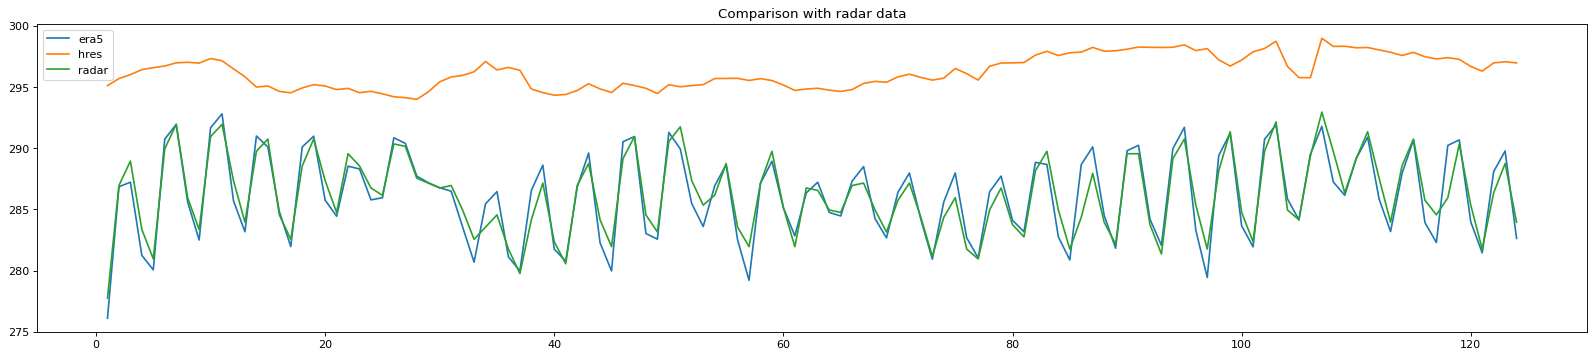

In [94]:
t = np.arange(1,125)

fig=plt.figure(figsize=(25, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(t,delhi_era5, color='C0', label='era5')
plt.plot(t,delhi_hres, color='C1', label='hres')
plt.plot(t,delhi_data['temp'][::6].values + 273.16, color='C2', label='radar')
plt.legend()
plt.title('Comparison with radar data')

In [40]:


lat

array([ 90.  ,  89.75,  89.5 ,  89.25,  89.  ,  88.75,  88.5 ,  88.25,
        88.  ,  87.75,  87.5 ,  87.25,  87.  ,  86.75,  86.5 ,  86.25,
        86.  ,  85.75,  85.5 ,  85.25,  85.  ,  84.75,  84.5 ,  84.25,
        84.  ,  83.75,  83.5 ,  83.25,  83.  ,  82.75,  82.5 ,  82.25,
        82.  ,  81.75,  81.5 ,  81.25,  81.  ,  80.75,  80.5 ,  80.25,
        80.  ,  79.75,  79.5 ,  79.25,  79.  ,  78.75,  78.5 ,  78.25,
        78.  ,  77.75,  77.5 ,  77.25,  77.  ,  76.75,  76.5 ,  76.25,
        76.  ,  75.75,  75.5 ,  75.25,  75.  ,  74.75,  74.5 ,  74.25,
        74.  ,  73.75,  73.5 ,  73.25,  73.  ,  72.75,  72.5 ,  72.25,
        72.  ,  71.75,  71.5 ,  71.25,  71.  ,  70.75,  70.5 ,  70.25,
        70.  ,  69.75,  69.5 ,  69.25,  69.  ,  68.75,  68.5 ,  68.25,
        68.  ,  67.75,  67.5 ,  67.25,  67.  ,  66.75,  66.5 ,  66.25,
        66.  ,  65.75,  65.5 ,  65.25,  65.  ,  64.75,  64.5 ,  64.25,
        64.  ,  63.75,  63.5 ,  63.25,  63.  ,  62.75,  62.5 ,  62.25,
      

ValueError: x and y can be no greater than 2D, but have shapes (124,) and (124, 721, 1440)

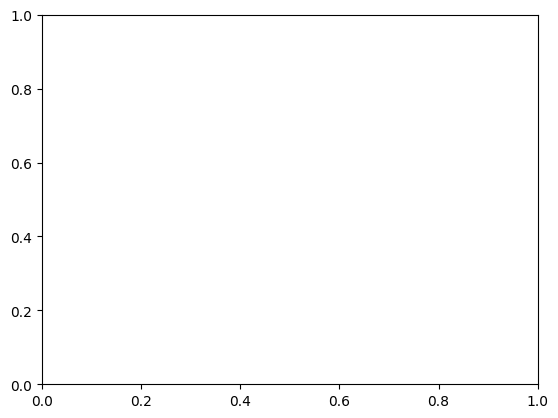

In [33]:
plt.plot(t_era5)